In [166]:
%reload_ext autoreload
%autoreload 2

In [167]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon

In [168]:
# TODO: implement function as separate module when ready
# import povertymapping.viirs_data_proc as viirs

In [169]:
import sys

In [170]:
viirs_config = dict(
        save_path="../data/outputs/viirs_ph",
        repo_path="../data/SVII_PH_KH_MM_TL",
        viirs_tif_path="../data/outputs/viirs_ph/eog_PH_2017.tif",
        data_dir="ph",
        country="ph",
        viirs_folder="viirs_ph",
        hdx_folder="hdx_ph",
        dhs_folder="dhs_ph",
        dhs_geo_zip_folder="PHGE71FL",
        dhs_zip_folder="PHHR71DT",
        crs="4683",
        viirs_feature="avg_rad",
        boundary_file="phl_adminboundaries_candidate_adm3",
        year="2017",
        # sample=False,
        # random_sample=False,
        # no_samples=60,
        # random_seed=42,
        clust_rad=2000,
        plot_viirs_features=True,
        adm_level=3,
        use_pcode=True,
        shape_label='ADM3_PCODE',
        bins=6,
        show_legend=False,
    )

In [171]:
from pathlib import Path

In [172]:
# # uncomment and run the following to clear out the preprocessed files 
# !rm -rf {viirs_config['save_path']}
# !mkdir -p {viirs_config['save_path']}

In [173]:
cluster_coords_path = Path(viirs_config['save_path'])/'..'/viirs_config['dhs_folder']/f"{viirs_config['dhs_geo_zip_folder']}_cluster_coords.csv"
cluster_coords_path

PosixPath('../data/outputs/viirs_ph/../dhs_ph/PHGE71FL_cluster_coords.csv')

In [174]:
!cp {cluster_coords_path} {viirs_config['save_path']}/.

### Dev process_viirs_data()

In [175]:
viirs_tif_path = viirs_config['viirs_tif_path']

#### Open the tif file

In [176]:
with rio.open(viirs_tif_path) as dst:
    data = dst.read(1)
    print(data)

[[0.18399812 0.19208178 0.2039444  ... 0.15316088 0.1800387  0.17428316]
 [0.17762764 0.19316964 0.20672373 ... 0.17014433 0.18852577 0.182408  ]
 [0.18640055 0.19541879 0.18461716 ... 0.17492227 0.1974811  0.20390633]
 ...
 [0.24877347 0.25129357 0.280608   ... 0.18944512 0.19984274 0.23967312]
 [0.25689214 0.24893636 0.26223662 ... 0.2096378  0.22604159 0.25103217]
 [0.236746   0.22991171 0.2760854  ... 0.1685332  0.1776291  0.23493679]]


In [177]:
cluster_centroids_df = pd.read_csv(cluster_coords_path)

# Remove 
cluster_centroids_df = cluster_centroids_df[cluster_centroids_df.LATNUM > 0.0]

cluster_centroids_df.head(2)

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,PH201700000386,PH,2017.0,386.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,Ilocos,GPS,R,18.271892,120.564542,9999.0,17.0,WGS84,POINT (120.56454229 18.2718920623)
1,PH201700000387,PH,2017.0,387.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,Ilocos,GPS,U,18.202195,120.568506,9999.0,10.0,WGS84,POINT (120.568506409 18.2021947961)


In [178]:
cluster_centroids_gdf = gpd.GeoDataFrame(
    cluster_centroids_df,
    geometry=gpd.GeoSeries.from_wkt(cluster_centroids_df["geometry"])
)
cluster_centroids_gdf.head(2)

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,PH201700000386,PH,2017.0,386.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,Ilocos,GPS,R,18.271892,120.564542,9999.0,17.0,WGS84,POINT (120.56454 18.27189)
1,PH201700000387,PH,2017.0,387.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,Ilocos,GPS,U,18.202195,120.568506,9999.0,10.0,WGS84,POINT (120.56851 18.20219)


<AxesSubplot: >

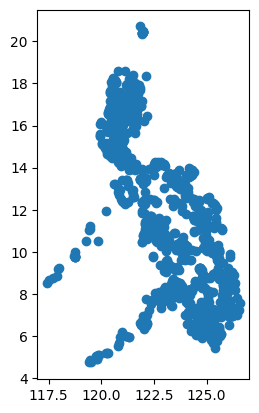

In [179]:
cluster_centroids_gdf.plot()

In [180]:
from haversine import Direction, inverse_haversine

In [181]:
def create_polygon_bbox(centroid_lat, centroid_lon, distance_km):
    """Return bbox edge locations using haversine distance function
    The output is specified as (west, south, east, north)
    distance_km specifies the distance of each edge from the centroid
    """
    centroid = (centroid_lat, centroid_lon)
    top_left = inverse_haversine(
        inverse_haversine(centroid, distance_km, Direction.WEST),
        distance_km,
        Direction.NORTH,
    )
    bottom_right = inverse_haversine(
        inverse_haversine(centroid, distance_km, Direction.EAST),
        distance_km,
        Direction.SOUTH,
    )

    north, west = top_left
    south, east = bottom_right

    # check inequalities
    assert west < east
    assert south < north

    bbox_coord_list = [west, south, east, north]

    bbox = Polygon([[west, south], [east, south], [east, north], [west, north]])
    return bbox


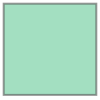

In [182]:
create_polygon_bbox(10,10,10)

In [183]:
def add_bbox_geom(cluster_centroids_gdf, distance_km, output_col='bbox'):
    """Add bbox geometry to dhs cluster data (i.e. 6th column)
    Args:
        cluster_centroid_gdf (gpd.GeoDataFrame): DHS data frame
        length (int): buffer radius in meters
    Returns:
        geopandas.GeoDataFrame
    """

    cluster_centroids_gdf = cluster_centroids_gdf.copy()

    centroids = list(
        zip(cluster_centroids_gdf["LATNUM"], cluster_centroids_gdf["LONGNUM"])
    )
    bbox_geometry = []
    print("Adding buffer geometry...")
    for centroid in tqdm(centroids):
        centroid_lat, centroid_lon = centroid
        bbox = create_polygon_bbox(centroid_lat, centroid_lon, distance_km)
        
        bbox_geometry.append(bbox)
    cluster_centroids_gdf[output_col] = bbox_geometry
    return cluster_centroids_gdf

In [184]:
cluster_bbox_gdf = add_bbox_geom(cluster_centroids_gdf, 2)
cluster_bbox_gdf['geometry'] = cluster_bbox_gdf['bbox']

Adding buffer geometry...


100%|██████████| 1214/1214 [00:00<00:00, 22638.95it/s]


<AxesSubplot: >

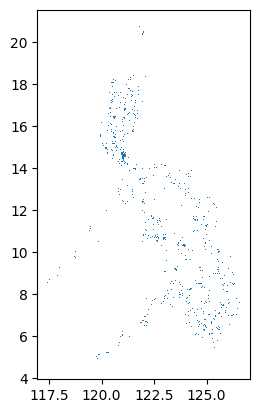

In [185]:
cluster_bbox_gdf.plot()

#### Raster zonal stats

In [186]:
import geowrangler.raster_zonal_stats as rzs

In [187]:
cluster_zonal_stats_gdf = rzs.create_raster_zonal_stats(
    cluster_bbox_gdf,
    viirs_tif_path,
    aggregation=dict(
        # func=["min", "max", "mean", "median", "kurtosis", "var"],
        func=["min", "max", "mean", "median", "std"],
        column="avg_rad",
    ),
    extra_args=dict(band_num=1, nodata=np.nan),
)


In [188]:
cluster_zonal_stats_gdf.head()

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,ALT_GPS,ALT_DEM,DATUM,geometry,bbox,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median
0,PH201700000386,PH,2017.0,386.0,NaN,NaN,NaN,NaN,NaN,1.0,...,9999.0,17.0,WGS84,"POLYGON ((120.54560 18.25390, 120.58348 18.253...",POLYGON ((120.54560084371413 18.25390472288926...,0.196119,1.391538,0.410263,0.260675,0.279534
1,PH201700000387,PH,2017.0,387.0,NaN,NaN,NaN,NaN,NaN,1.0,...,9999.0,10.0,WGS84,"POLYGON ((120.54957 18.18421, 120.58744 18.184...",POLYGON ((120.54957255328522 18.18420746049634...,0.389053,7.300686,2.008298,1.305749,1.690995
2,PH201700000388,PH,2017.0,388.0,NaN,NaN,NaN,NaN,NaN,1.0,...,9999.0,39.0,WGS84,"POLYGON ((120.67219 18.05593, 120.71003 18.055...",POLYGON ((120.67219287500379 18.05592686509549...,0.246468,0.511665,0.347220,0.056467,0.338678
3,PH201700000389,PH,2017.0,389.0,NaN,NaN,NaN,NaN,NaN,1.0,...,9999.0,13.0,WGS84,"POLYGON ((120.49128 18.04303, 120.52912 18.043...","POLYGON ((120.4912846023381 18.04302918609864,...",0.268062,6.462383,0.901461,1.259600,0.446334
4,PH201700000390,PH,2017.0,390.0,NaN,NaN,NaN,NaN,NaN,1.0,...,9999.0,126.0,WGS84,"POLYGON ((120.64414 18.13771, 120.68200 18.137...",POLYGON ((120.64414493860735 18.13770683763467...,0.319517,2.658939,0.610296,0.413121,0.499302


In [189]:
cluster_zonal_stats_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1214 entries, 0 to 1249
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DHSID           1214 non-null   object  
 1   DHSCC           1214 non-null   object  
 2   DHSYEAR         1214 non-null   float64 
 3   DHSCLUST        1214 non-null   float64 
 4   CCFIPS          0 non-null      float64 
 5   ADM1FIPS        0 non-null      float64 
 6   ADM1FIPSNA      0 non-null      float64 
 7   ADM1SALBNA      0 non-null      float64 
 8   ADM1SALBCO      0 non-null      float64 
 9   ADM1DHS         1214 non-null   float64 
 10  ADM1NAME        1214 non-null   object  
 11  DHSREGCO        1214 non-null   float64 
 12  DHSREGNA        1214 non-null   object  
 13  SOURCE          1214 non-null   object  
 14  URBAN_RURA      1214 non-null   object  
 15  LATNUM          1214 non-null   float64 
 16  LONGNUM         1214 non-null   float64 
 17  ALT_GP

## Compare with kahlil

In [190]:
kahlil_cluster_zonal_stats_gdf = gpd.read_file(
    "../data/outputs/viirs_ph/rzs_dhs_viirs_ph_2017.gpkg"
)


In [191]:
kahlil_cluster_zonal_stats_gdf.head(3)

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,ALT_GPS,ALT_DEM,DATUM,rzs_mean,rzs_median,rzs_stdev,rzs_min,rzs_max,rzs_variance,geometry
0,1,-31881.608696,PH201700000001,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,9999.0,10.0,WGS84,0.265912,0.261700,0.029590,0.222937,0.375542,0.000876,"MULTIPOLYGON (((403606.834 739871.878, 403606...."
1,2,-2855.375000,PH201700000002,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,9999.0,5.0,WGS84,0.981981,0.346526,1.325483,0.224869,6.881082,1.756904,"MULTIPOLYGON (((406060.603 738497.001, 406060...."
2,3,-57647.047619,PH201700000003,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,9999.0,47.0,WGS84,0.328983,0.288842,0.115563,0.224655,0.865518,0.013355,"MULTIPOLYGON (((411300.477 734017.843, 411300...."


In [192]:
kahlil_cluster_zonal_stats_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   DHSCLUST      1249 non-null   int64   
 1   Wealth Index  1249 non-null   float64 
 2   DHSID         1249 non-null   object  
 3   DHSCC         1249 non-null   object  
 4   DHSYEAR       1249 non-null   float64 
 5   CCFIPS        1249 non-null   object  
 6   ADM1FIPS      1249 non-null   object  
 7   ADM1FIPSNA    1249 non-null   object  
 8   ADM1SALBNA    1249 non-null   object  
 9   ADM1SALBCO    1249 non-null   object  
 10  ADM1DHS       1249 non-null   float64 
 11  ADM1NAME      1249 non-null   object  
 12  DHSREGCO      1249 non-null   float64 
 13  DHSREGNA      1249 non-null   object  
 14  SOURCE        1249 non-null   object  
 15  URBAN_RURA    1249 non-null   object  
 16  LATNUM        1249 non-null   float64 
 17  LONGNUM       1249 non-null   float64 
 18  

In [193]:
usecols_left = [
    "DHSID",
    "avg_rad_min",
    "avg_rad_max",
    "avg_rad_mean",
    "avg_rad_std",
    "avg_rad_median",
]
cluster_zonal_stats_gdf = cluster_zonal_stats_gdf[usecols_left]
cluster_zonal_stats_gdf 


,DHSID,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median
0,PH201700000386,0.196119,1.391538,0.410263,0.260675,0.279534
1,PH201700000387,0.389053,7.300686,2.008298,1.305749,1.690995
2,PH201700000388,0.246468,0.511665,0.347220,0.056467,0.338678
3,PH201700000389,0.268062,6.462383,0.901461,1.259600,0.446334
4,PH201700000390,0.319517,2.658939,0.610296,0.413121,0.499302
...,...,...,...,...,...,...
1245,PH201700000722,NaN,NaN,NaN,NaN,NaN
1246,PH201700000723,NaN,NaN,NaN,NaN,NaN
1247,PH201700000724,NaN,NaN,NaN,NaN,NaN
1248,PH201700000725,NaN,NaN,NaN,NaN,NaN


In [194]:
cluster_zonal_stats_gdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214 entries, 0 to 1249
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DHSID           1214 non-null   object 
 1   avg_rad_min     1178 non-null   float64
 2   avg_rad_max     1178 non-null   float64
 3   avg_rad_mean    1178 non-null   float64
 4   avg_rad_std     1178 non-null   float64
 5   avg_rad_median  1178 non-null   float64
dtypes: float64(5), object(1)
memory usage: 98.7+ KB


In [195]:
usecols_right = [
    "DHSID",
    "rzs_min",
    "rzs_max",
    "rzs_mean",
    "rzs_stdev",
    "rzs_median",
]
kahlil_cluster_zonal_stats_gdf = kahlil_cluster_zonal_stats_gdf[usecols_right]
kahlil_cluster_zonal_stats_gdf

,DHSID,rzs_min,rzs_max,rzs_mean,rzs_stdev,rzs_median
0,PH201700000001,0.222937,0.375542,0.265912,0.029590,0.261700
1,PH201700000002,0.224869,6.881082,0.981981,1.325483,0.346526
2,PH201700000003,0.224655,0.865518,0.328983,0.115563,0.288842
3,PH201700000004,0.184109,0.341882,0.230732,0.022960,0.226286
4,PH201700000005,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1244,PH201700001246,0.260100,0.541940,0.371548,0.058022,0.367754
1245,PH201700001247,0.163501,0.306702,0.238562,0.030196,0.238538
1246,PH201700001248,0.386377,9.535286,1.729907,1.793547,0.912327
1247,PH201700001249,0.226791,0.469200,0.313033,0.045507,0.305297


In [196]:
kahlil_cluster_zonal_stats_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DHSID       1249 non-null   object 
 1   rzs_min     1213 non-null   float64
 2   rzs_max     1213 non-null   float64
 3   rzs_mean    1213 non-null   float64
 4   rzs_stdev   1213 non-null   float64
 5   rzs_median  1213 non-null   float64
dtypes: float64(5), object(1)
memory usage: 58.7+ KB


In [197]:
# Merge
cluster_zonal_stats_gdf['DHSID'] = cluster_zonal_stats_gdf['DHSID'].astype(str)
kahlil_cluster_zonal_stats_gdf['DHSID'] = kahlil_cluster_zonal_stats_gdf['DHSID'].astype(str)
combined_zonal_stats = cluster_zonal_stats_gdf.merge(kahlil_cluster_zonal_stats_gdf, on=["DHSID"], how="outer")

combined_zonal_stats


,DHSID,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median,rzs_min,rzs_max,rzs_mean,rzs_stdev,rzs_median
0,PH201700000386,0.196119,1.391538,0.410263,0.260675,0.279534,0.196119,1.391538,0.405251,0.259855,0.275098
1,PH201700000387,0.389053,7.300686,2.008298,1.305749,1.690995,0.389053,8.644136,2.131632,1.524006,1.712358
2,PH201700000388,0.246468,0.511665,0.347220,0.056467,0.338678,0.246468,0.511665,0.347220,0.056467,0.338678
3,PH201700000389,0.268062,6.462383,0.901461,1.259600,0.446334,0.268062,6.462383,0.872115,1.223619,0.415388
4,PH201700000390,0.319517,2.658939,0.610296,0.413121,0.499302,0.318214,2.658939,0.603239,0.409725,0.483755
...,...,...,...,...,...,...,...,...,...,...,...
1245,PH201700000874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1246,PH201700001197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1247,PH201700001209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1248,PH201700001213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
zonal_stat_pairs = list(zip(usecols_left,usecols_right))[1:]
zonal_stat_pairs

[('avg_rad_min', 'rzs_min'),
 ('avg_rad_max', 'rzs_max'),
 ('avg_rad_mean', 'rzs_mean'),
 ('avg_rad_std', 'rzs_stdev'),
 ('avg_rad_median', 'rzs_median')]

In [199]:
for pair in zonal_stat_pairs:
    usecols = ['DHSID'] + list(pair)
    print(usecols)

    display(combined_zonal_stats[usecols])
    df['A'].hist()
    df['B'].hist()


['DHSID', 'avg_rad_min', 'rzs_min']


,DHSID,avg_rad_min,rzs_min
0,PH201700000386,0.196119,0.196119
1,PH201700000387,0.389053,0.389053
2,PH201700000388,0.246468,0.246468
3,PH201700000389,0.268062,0.268062
4,PH201700000390,0.319517,0.318214
...,...,...,...
1245,PH201700000874,NaN,NaN
1246,PH201700001197,NaN,NaN
1247,PH201700001209,NaN,NaN
1248,PH201700001213,NaN,NaN


['DHSID', 'avg_rad_max', 'rzs_max']


,DHSID,avg_rad_max,rzs_max
0,PH201700000386,1.391538,1.391538
1,PH201700000387,7.300686,8.644136
2,PH201700000388,0.511665,0.511665
3,PH201700000389,6.462383,6.462383
4,PH201700000390,2.658939,2.658939
...,...,...,...
1245,PH201700000874,NaN,NaN
1246,PH201700001197,NaN,NaN
1247,PH201700001209,NaN,NaN
1248,PH201700001213,NaN,NaN


['DHSID', 'avg_rad_mean', 'rzs_mean']


,DHSID,avg_rad_mean,rzs_mean
0,PH201700000386,0.410263,0.405251
1,PH201700000387,2.008298,2.131632
2,PH201700000388,0.347220,0.347220
3,PH201700000389,0.901461,0.872115
4,PH201700000390,0.610296,0.603239
...,...,...,...
1245,PH201700000874,NaN,NaN
1246,PH201700001197,NaN,NaN
1247,PH201700001209,NaN,NaN
1248,PH201700001213,NaN,NaN


['DHSID', 'avg_rad_std', 'rzs_stdev']


,DHSID,avg_rad_std,rzs_stdev
0,PH201700000386,0.260675,0.259855
1,PH201700000387,1.305749,1.524006
2,PH201700000388,0.056467,0.056467
3,PH201700000389,1.259600,1.223619
4,PH201700000390,0.413121,0.409725
...,...,...,...
1245,PH201700000874,NaN,NaN
1246,PH201700001197,NaN,NaN
1247,PH201700001209,NaN,NaN
1248,PH201700001213,NaN,NaN


['DHSID', 'avg_rad_median', 'rzs_median']


,DHSID,avg_rad_median,rzs_median
0,PH201700000386,0.279534,0.275098
1,PH201700000387,1.690995,1.712358
2,PH201700000388,0.338678,0.338678
3,PH201700000389,0.446334,0.415388
4,PH201700000390,0.499302,0.483755
...,...,...,...
1245,PH201700000874,NaN,NaN
1246,PH201700001197,NaN,NaN
1247,PH201700001209,NaN,NaN
1248,PH201700001213,NaN,NaN
